<a href="https://colab.research.google.com/github/Junha9/AI/blob/master/Self_Learning_ML_DL/Chapter_08_2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# import statements
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [21]:
# Prepare the data
fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

train_input = fm_train.data
train_target = fm_train.targets
train_scaled = train_input.reshape(-1, 1, 28, 28) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [22]:
# Build convolution layer first
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(1, 32, kernel_size=3, padding='same'))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('conv2', nn.Conv2d(32, 64, kernel_size=3, padding='same'))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('flatten', nn.Flatten())

In [23]:
# Check the output shape
output = model(torch.ones(1,1,28,28))
print(output.shape)

torch.Size([1, 3136])


In [24]:
# Add dropout and dense layer
model.add_module('dense1', nn.Linear(3136, 100))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('dense2', nn.Linear(100, 10))

In [25]:
# Prepare loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [26]:
# When using pytorch it's better to make dataset using TensorDataset
train_dataset = TensorDataset(train_scaled, train_target)
val_dataset = TensorDataset(val_scaled, val_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [27]:
# Training codes
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 20

for epoch in range(epochs):
  model.train()
  train_loss = 0
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for inputs, targets in val_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      val_loss += loss.item()
  train_loss = train_loss / len(train_loader)
  val_loss = val_loss / len(val_loader)
  train_hist.append(train_loss)
  val_hist.append(val_loss)
  print(f"epoch: {epoch+1},",
        f"train loss: {train_loss:.4f}, val_loss:{val_loss:.4f}")
  if best_loss == -1 or val_loss < best_loss:
    best_loss = val_loss
    early_stopping_counter = 0
    torch.save(model.state_dict(), 'best_cnn_model.pt')
  else:
    early_stopping_counter += 1
    if early_stopping_counter >= patience:
      print(f"early stopped in {epoch+1}th epoch")
      break



epoch: 1, train loss: 0.5132, val_loss:0.3433
epoch: 2, train loss: 0.3368, val_loss:0.2798
epoch: 3, train loss: 0.2904, val_loss:0.2550
epoch: 4, train loss: 0.2588, val_loss:0.2462
epoch: 5, train loss: 0.2344, val_loss:0.2288
epoch: 6, train loss: 0.2140, val_loss:0.2210
epoch: 7, train loss: 0.1945, val_loss:0.2172
epoch: 8, train loss: 0.1817, val_loss:0.2172
epoch: 9, train loss: 0.1642, val_loss:0.2221
early stopped in 9th epoch


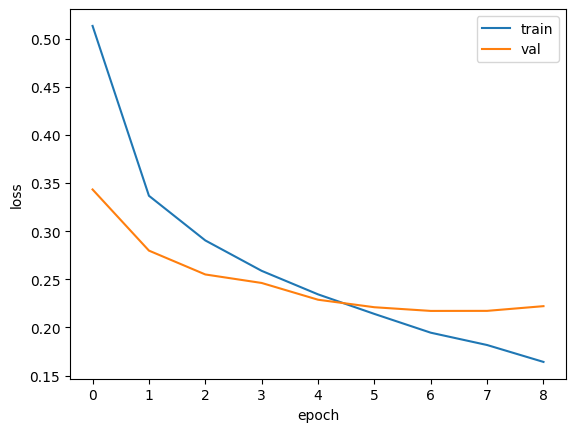

In [28]:
# Training completed. let's see
plt.plot(train_hist, label='train')
plt.plot(val_hist, label = 'val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [29]:
# seems overfitting occurs after 5th epoch. Let's load and evaluate the model.
model.load_state_dict(torch.load('best_cnn_model.pt', weights_only=True))

model.eval()
corrects = 0
with torch.no_grad():
  for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    predicts = torch.argmax(outputs, 1)
    corrects += (predicts == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"validation accuracy: {accuracy:.4f}")

validation accuracy: 0.9201


In [30]:
# Now finally, get accuracy from the test set
test_scaled = fm_test.data.reshape(-1, 1, 28, 28) / 255.0
test_target = fm_test.targets

test_dataset = TensorDataset(test_scaled, test_target)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
model.eval()
corrects = 0
with torch.no_grad():
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    predicts = torch.argmax(outputs, 1)
    corrects += (predicts == targets).sum().item()

accuracy = corrects / len(test_dataset)
print(f"test accuracy: {accuracy:.4f}")

test accuracy: 0.9141
